In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
import matplotlib.pyplot as plt
set_seed(3407)

c:\Users\mcasa\anaconda3\envs\nlpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input = "Michelle Jones was a top-notch student. Michelle"
print("Input:", input)
bpe = BPETokenizer()
# bpe() gets a string and returns a 2D batch tensor 
# of indices with shape (1, input_length)
tokens = bpe(input)[0]
print("Tokenized input:", tokens)
input_length = tokens.shape[-1]
print("Number of input tokens:", input_length)
# bpe.decode gets a 1D tensor (list of indices) and returns a string
print("Detokenized input from indices:", bpe.decode(tokens))  
tokens_str = []
for token in tokens:
    decoded_token = bpe.decode(torch.tensor([token]))
    tokens_str.append(decoded_token)
print("Detokenized input as strings: " + '/'.join(tokens_str))


Input: Michelle Jones was a top-notch student. Michelle
Tokenized input: tensor([48736,  5437,   373,   257,  1353,    12,  1662,   354,  3710,    13,
        16738])
Number of input tokens: 11
Detokenized input from indices: Michelle Jones was a top-notch student. Michelle
Detokenized input as strings: Michelle/ Jones/ was/ a/ top/-/not/ch/ student/./ Michelle


In [45]:

def generate(prompt='', num_samples=10, steps=20, do_sample=True):


# tokenize the input prompt into integer input sequence
    tokenizer = BPETokenizer()
    if prompt == '':
        # to create unconditional samples...
        # manually create a tensor with only the special <|endoftext|> token
        # similar to what openai's code does here https://github.com/openai/gpt-2/blob/master/src/generate_unconditional_samples.py
        x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
    else:
        x = tokenizer(prompt).to(device)
    
    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)
    
    # Write outputs to file
    with open('output2.txt', 'a', encoding='utf-8') as f:
        f.write('-------------------------- Prompt: ' + prompt + '-----------------\n\n')
        for i in range(num_samples):
            out = tokenizer.decode(y[i].cpu().squeeze())
            print('-'*80)
            print(out)
            f.write(out + '\n' + '-' * 80 + '\n')
        f.write('\n\n\n\n')
        

In [46]:
inputs =['Michelle Jones was a top-notch student. Michelle',
         'Michelle Smith was a top-notch student. Michelle',
         'Jessica Jones was a top-notch student. Michelle',
         'Michelle Smith was a top-notch student. Jessica']

for input in inputs:
    generate(prompt=input, num_samples=5, steps=20, do_sample=True)

--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle graduated with a degree in criminal justice in June 2014, but she's not back in school this semester
--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle was a member of our varsity volleyball team, and she was a member of our club tennis team
--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle started at the University of Southern California at the end of the 9th grade. She was a freshman
--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle was smart, she had a good personality, she worked hard, she got good grades, and she
--------------------------------------------------------------------------------
Michelle Jones was a top-n

# Implementation for the experiment

number of parameters: 124.44M


C:\Users\mcasa\AppData\Local\Temp\ipykernel_11488\2204593842.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(inputs).unsqueeze(0).to(device)  # Convert list to tensor, add batch dimension, and move to device


Clean logics shape: torch.Size([10, 50257])
Clean IDs shape: torch.Size([1, 11])
Shape for probs: torch.Size([10, 50257])
Shape for token_ids: torch.Size([1, 11])
Shape for probs: torch.Size([10, 50257])
Shape for token_ids: torch.Size([1, 11])
Logit differences shape: torch.Size([10, 50257])
Prob differences shape: torch.Size([10, 1])
tensor([48736,  5437,   373,   257,  1353,    12,  1662,   354,  3710,    13,
        16738])


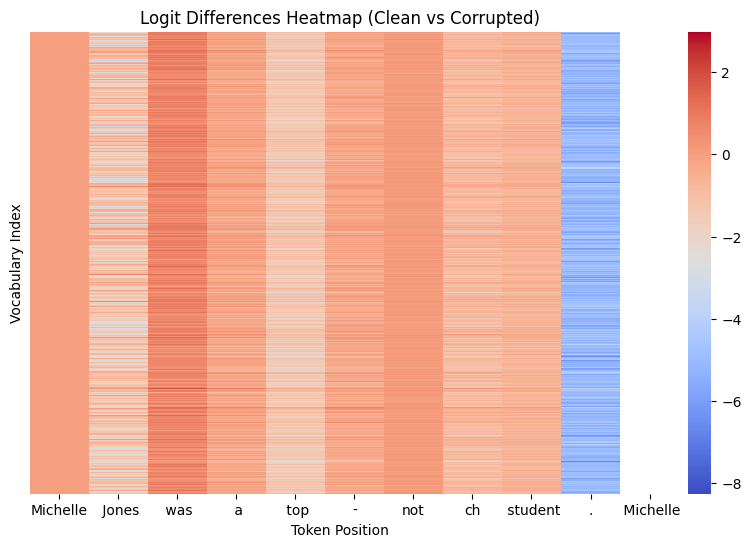

Token: Michelle | Clean Prob: [0.00015398] | Corrupt Prob: [0.00029042] | Diff: -0.0001
Token:  Jones | Clean Prob: [0.02482481] | Corrupt Prob: [0.01905396] | Diff: 0.0058
Token:  was | Clean Prob: [0.05865587] | Corrupt Prob: [0.05543475] | Diff: 0.0032
Token:  a | Clean Prob: [0.00283272] | Corrupt Prob: [0.00265784] | Diff: 0.0002
Token:  top | Clean Prob: [0.07957] | Corrupt Prob: [0.09510823] | Diff: -0.0155
Token: - | Clean Prob: [0.05706855] | Corrupt Prob: [0.08500407] | Diff: -0.0279
Token: not | Clean Prob: [0.9994777] | Corrupt Prob: [0.9995746] | Diff: -0.0001
Token: ch | Clean Prob: [0.00584446] | Corrupt Prob: [0.00977239] | Diff: -0.0039
Token:  student | Clean Prob: [0.05677653] | Corrupt Prob: [0.06671336] | Diff: -0.0099
Token: . | Clean Prob: [0.00036087] | Corrupt Prob: [0.00041878] | Diff: -0.0001


In [8]:
import torch
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load GPT-2 model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BPETokenizer()
model = GPT.from_pretrained('gpt2')
model.eval()

# Define clean and corrupted texts
clean_text = "Michelle Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Michelle"

def get_token_logits(text):
    # Tokenize the text using BPETokenizer
    inputs = tokenizer(text)  # Get a list of token IDs

    input_ids = torch.tensor(inputs).unsqueeze(0).to(device)  # Convert list to tensor, add batch dimension, and move to device

    with torch.no_grad():
        outputs = model.forward(input_ids[0])  # Get logits from the model
    
    # The output is likely a tuple, so we need to unpack it
    logits = outputs[0]  # The logits are typically the first element in the tuple

    logits = logits[0, :-1, :]  # Extract logits for all tokens except the last one
    return logits, input_ids[0]



# Get logits for clean and corrupted inputs
clean_logits, clean_ids = get_token_logits(clean_text)
corrupted_logits, corrupted_ids = get_token_logits(corrupted_text)

print("Clean logics shape:", clean_logits.shape)

print("Clean IDs shape:", clean_ids.shape)


# Convert logits to probabilities
def get_token_probabilities(logits, token_ids):
    # Apply softmax to convert logits to probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)
    print("Shape for probs:", probs.shape)
    print("Shape for token_ids:", token_ids.shape)

    # Fix token_ids to match the sequence length of logits (10 tokens, not 11)
    token_ids = token_ids.squeeze(0)  # Remove the batch dimension (shape becomes [11])
    
    # Remove the first token, which is often padding or a special token
    token_ids = token_ids[1:]  # Now token_ids has shape [10], matching the sequence length of probs

    # Gather probabilities for the specific tokens in the sequence
    token_probs = torch.gather(probs, dim=-1, index=token_ids.unsqueeze(-1))  # Skip the first token
    return token_probs.cpu().numpy()

clean_probs = get_token_probabilities(clean_logits, clean_ids)
corrupted_probs = get_token_probabilities(corrupted_logits, corrupted_ids)

# Compute logit differences
logit_diff = (clean_logits - corrupted_logits).cpu().numpy()
prob_diff = (clean_probs - corrupted_probs)

logit_diff = torch.tensor(logit_diff)
prob_diff = torch.tensor(prob_diff)

print("Logit differences shape:", logit_diff.shape)
print("Prob differences shape:", prob_diff.shape)

print(clean_ids[0])
tokens_str = []
for token in clean_ids[0]:
    decoded_token = tokenizer.decode(torch.tensor([token]))
    tokens_str.append(decoded_token)


# Visualize the results
plt.figure(figsize=(10, 6))
sns.heatmap(logit_diff.T, cmap="coolwarm", annot=False, xticklabels=tokens_str, yticklabels=False)

plt.title("Logit Differences Heatmap (Clean vs Corrupted)")
plt.xlabel("Token Position")
plt.ylabel("Vocabulary Index")
plt.show()

# Print analysis results for token probabilities
for i, (clean, corrupt, diff) in enumerate(zip(clean_probs, corrupted_probs, prob_diff)):
    t = torch.tensor([clean_ids[0][i]])
    token = tokenizer.decode(t)
    print(f"Token: {token} | Clean Prob: {clean} | Corrupt Prob: {corrupt} | Diff: {diff[0]:.4f}")


In [9]:
class GPTWithEmbeddings(GPT):
    def __init__(self, config):
        self.config = config
        super().__init__(config)  # Call the constructor of the parent class (GPT)
        
    @classmethod
    def from_pretrained(cls, model_type):
        """
        Initialize a pretrained GPT model by copying over the weights
        from a huggingface/transformers checkpoint.
        """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel

        # create a from-scratch initialized minGPT model
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 50257 # openai's model vocabulary
        config.block_size = 1024  # openai's model block_size
        model = cls(config)
        sd = model.state_dict()

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] # ignore these
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla nn.Linear.
        # this means that we have to transpose these weights when we import them
        assert len(keys) == len([k for k in sd if not k.endswith(".attn.bias")])
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def forward(self, idx, targets=None, embeddings_input=None):
      device = idx.device if idx is not None else embeddings_input.device
      if idx is not None:
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
      else:
        x = embeddings_input
        b, t, _ = x.shape
      
      all_embeddings = [x.detach().cpu()] # Store initial embeddings
      
      x = self.transformer.drop(x)
      for block in self.transformer.h:
          x = block(x)
          all_embeddings.append(x.detach().cpu()) # Store embeddings after each block
      x = self.transformer.ln_f(x)
      all_embeddings.append(x.detach().cpu()) # Store embeddings after layer norm

      logits = self.lm_head(x)

      # if we are given some desired targets also calculate the loss
      loss = None
      if targets is not None:
          loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

      return logits, loss, torch.stack(all_embeddings, dim=2)

In [53]:
# Load GPT-2 model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BPETokenizer()
# Load and wrap with GPTWithEmbeddings, directly to the correct device
model = GPTWithEmbeddings.from_pretrained('gpt2').to(device)

# Ensure the model is the correct class
assert isinstance(model, GPTWithEmbeddings), f"Model is not an instance of GPTWithEmbeddings, but {type(model)}"
model.eval()

number of parameters: 124.44M


GPTWithEmbeddings(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_

In [14]:
# Define clean and corrupted prompts
clean_prompt = "Michelle Jones was a top-notch student. Michelle"
corrupted_prompt = "Michelle Smith was a top-notch student. Michelle"

# Tokenize prompts
clean_tokens = tokenizer(clean_prompt)[0]
corrupted_tokens = tokenizer(corrupted_prompt)[0]

# Ensure prompts have the same number of tokens
assert len(clean_tokens) == len(corrupted_tokens), "Prompts must have the same number of tokens"
n_tokens = len(clean_tokens)
print("Number of tokens:", n_tokens)

Number of tokens: 11


In [44]:
# Get logits for clean prompt
clean_logits, _, clean_embeddings = model(clean_tokens.unsqueeze(0).to(device))
print("Clean logits shape:", clean_logits.shape)
print("Clean embeddings shape:", clean_embeddings.shape)

Clean logits shape: torch.Size([1, 11, 50257])
Clean embeddings shape: torch.Size([1, 11, 14, 768])


In [45]:
# Get logits for corrupted prompt
corrupted_logits, _, corrupted_embeddings = model(corrupted_tokens.unsqueeze(0).to(device))
print("Corrupted logits shape:", corrupted_logits.shape)
print("Corrupted embeddings shape:", corrupted_embeddings.shape)

Corrupted logits shape: torch.Size([1, 11, 50257])
Corrupted embeddings shape: torch.Size([1, 11, 14, 768])


In [17]:
# Find indices of tokens ' Smith' and ' Jones'
smith_index = tokenizer(' Smith').item()
jones_index = tokenizer(' Jones').item()
print("Smith index:", smith_index)
print("Jones index:", jones_index)

Smith index: 4176
Jones index: 5437


In [46]:
# Calculate logit difference between ' Smith' and ' Jones' for clean and corrupted prompts
clean_logit_diff = clean_logits[0, -1, smith_index] - clean_logits[0, -1, jones_index]
corrupted_logit_diff = corrupted_logits[0, -1, smith_index] - corrupted_logits[0, -1, jones_index]

print("Clean logit difference:", clean_logit_diff.item())
print("Corrupted logit difference:", corrupted_logit_diff.item())

Clean logit difference: -4.12408447265625
Corrupted logit difference: 5.65625


In [58]:
# Initialize matrix to store logit differences
logit_diff_matrix = torch.zeros((model.config.n_layer + 1, n_tokens))

# Iterate through layers and tokens
for layer in range(model.config.n_layer + 1):
    for token_pos in range(n_tokens):
        # Create a copy of corrupted embeddings
        patched_embeddings = corrupted_embeddings.clone()

        # Patch embeddings at specified layer and token position
        if layer < model.config.n_layer:
          patched_embeddings[0, token_pos, layer] = clean_embeddings[0, token_pos, layer]

        # Run model with patched embeddings
        patched_logits, _, _ = model(corrupted_tokens.unsqueeze(0).to(device), embeddings_input=patched_embeddings if layer < model.config.n_layer else None)

        # Calculate logit difference
        patched_logit_diff = patched_logits[0, -1, smith_index] - patched_logits[0, -1, jones_index]

        # Store logit difference
        logit_diff_matrix[layer, token_pos] = patched_logit_diff.item()

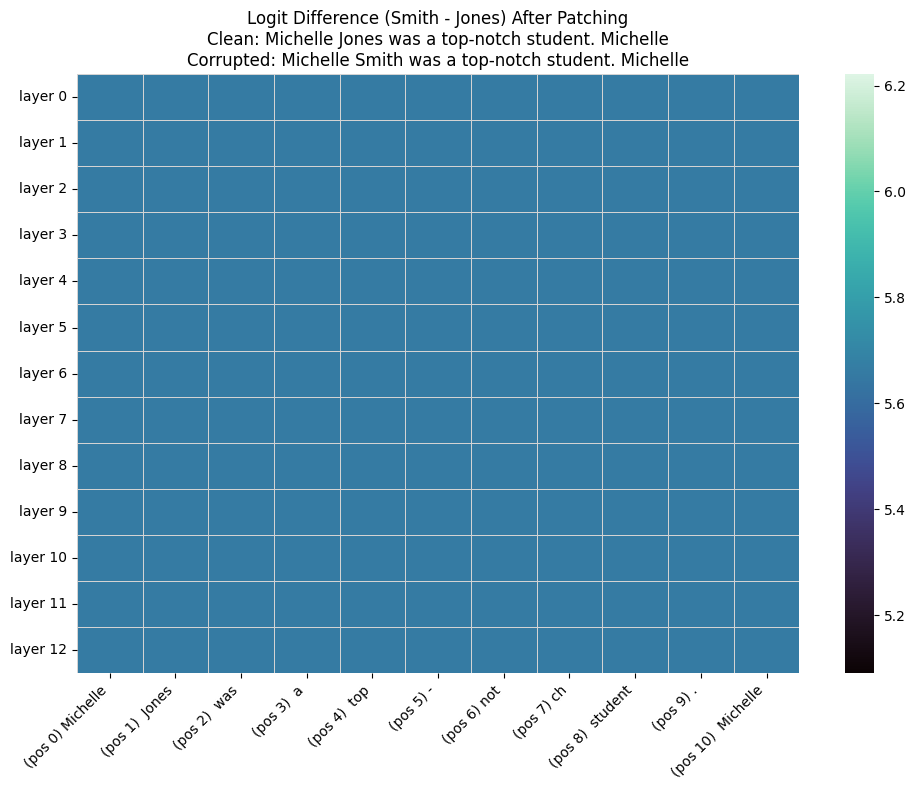

In [61]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(logit_diff_matrix.cpu().numpy(), cmap="mako", cbar=True, ax=ax,
            xticklabels=[f"(pos {i}) {tokenizer.decode(torch.tensor([clean_tokens[i]]))}" for i in range(n_tokens)],  # Convert to tensor here
            yticklabels=[f"layer {i}" for i in range(model.config.n_layer+1)],
            linewidths=0.5, linecolor='lightgrey')
plt.title(f"Logit Difference (Smith - Jones) After Patching\nClean: {clean_prompt}\nCorrupted: {corrupted_prompt}")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Try 2:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
import torch
from torch.nn import functional as F

/home/edu/Desktop/nlpt/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT.from_pretrained('gpt2').to(device)
tokenizer = BPETokenizer()

number of parameters: 124.44M


In [3]:
# Define clean and corrupted inputs
clean_text = "Michelle Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Michelle"

In [4]:
# Tokenize texts
clean_tokens = tokenizer(clean_text)[0]
corrupted_tokens = tokenizer(corrupted_text)[0]
assert clean_tokens.shape == corrupted_tokens.shape, "Tokens must have the same shape"
print("Number of tokens:", clean_tokens.shape[0])

Number of tokens: 11


In [5]:
# Generate from clean text
output = model.generate(clean_tokens.unsqueeze(0).to(device), max_new_tokens=1, do_sample=False)
print("Output from clean text:", tokenizer.decode(output[0].cpu()))

Output from clean text: Michelle Jones was a top-notch student. Michelle Jones


In [6]:
# Tokenize the clean text
clean_tokens = tokenizer(clean_text)[0].unsqueeze(0).to(device)

# Pass it through the model via the generate function
output = model.generate(clean_tokens, max_new_tokens=1, do_sample=False)

# Display the most probable continuations based on the logits of the last token
logits = model.activations[-1][0, -1]
probs = F.softmax(logits, dim=-1)
top_probs, top_indices = torch.topk(probs, k=20, dim=-1)
top_tokens = [tokenizer.decode(torch.tensor([idx])) for idx in top_indices]

print("Top 20 tokens at last position:")
for prob, token in zip(top_probs, top_tokens):
    print(f"{token}: {prob.item()}")

Top 20 tokens at last position:
�: 1.0
 will: 1.4001888190562362e-11
age: 2.093299034109221e-33
ra: 2.0629176106200793e-37
E: 3.3883396867374077e-42
 w: 1.517606236863777e-42
�: 2.382207389352189e-44
�: 1.1210387714598537e-44
�: 1.1210387714598537e-44
 d: 1.1210387714598537e-44
 there: 8.407790785948902e-45
ess: 5.605193857299268e-45
�: 2.802596928649634e-45
ove: 1.401298464324817e-45
oc: 1.401298464324817e-45
amp: 1.401298464324817e-45
 3: 0.0
.": 0.0
ime: 0.0
 said: 0.0


In [7]:
# Copy the activations of the clean text
clean_activations = [activation.clone().detach() for activation in model.activations]
print(len(clean_activations))
print(clean_activations[0].shape)

12
torch.Size([1, 11, 768])


In [8]:
# Get the indices of the " Smith" and " Jones" tokens
smith_index = tokenizer(" Smith")[0].item()
jones_index = tokenizer(" Jones")[0].item()

print("Smith index:", smith_index)
print("Jones index:", jones_index)

Smith index: 4176
Jones index: 5437


In [9]:
# Initialize matrix to store logit differences
logit_diff_matrix = torch.zeros((12, len(corrupted_tokens)))

# Iterate through layers and token positions
for layer in range(12):
    for pos in range(len(corrupted_tokens)):
        embedding_to_patch = clean_activations[layer][0, pos].clone()

        # Generate output with the corrupted text making patches in layer, pos
        logits, _ = model.forward(corrupted_tokens.unsqueeze(0).to(device), patch_embedding={
            "layer": layer,
            "position": pos,
            "embedding": embedding_to_patch
        })

        # Compute logits for the last token
        logits = model.last_token_logits
        
        # Calculate logit difference between ' Smith' and ' Jones'
        logit_diff = logits[0, smith_index] - logits[0, jones_index]

        # Store logit difference in the matrix
        logit_diff_matrix[layer, pos] = logit_diff.item()

# Print the logit difference matrix
print("Logit Difference Matrix:")
print(logit_diff_matrix)

Logit Difference Matrix:
tensor([[ 3.5720, -2.4119,  6.2768,  4.1233,  5.6479,  5.3318,  3.4217,  4.5002,
          4.7233,  4.9793,  5.0952],
        [ 4.3364, -0.2568,  6.4136,  4.0566,  5.0763,  3.9448,  2.7074,  6.3046,
          5.3636,  5.5958,  7.1994],
        [ 5.8622, -5.9325,  5.8679,  3.8642,  3.2961,  3.2402,  3.9108,  6.3872,
          3.3987,  4.4387,  4.6759],
        [ 6.9408, -3.4482,  6.4344,  3.6805,  6.3133,  3.4006,  3.8371,  4.5140,
          7.0802,  3.6599,  6.6144],
        [ 6.5842, -3.1370,  6.8846,  4.8829,  5.0762,  6.4659,  3.5921,  5.5183,
          5.1523,  4.3274,  6.5024],
        [ 6.4025, -1.7385,  5.7469,  6.8843,  2.6414,  6.6929,  6.1736,  3.6095,
          4.7028,  3.4634,  3.7282],
        [ 5.0861, -1.9111,  4.5342,  5.2177,  6.8519,  4.8100,  6.4871,  6.3760,
          2.6380,  7.7412,  5.1883],
        [ 4.5436,  0.3607,  4.9345,  5.1685,  2.6665,  4.2030,  6.9000,  5.4340,
          4.4030,  5.5615,  6.8387],
        [ 5.1875, -0.8065,  5.8

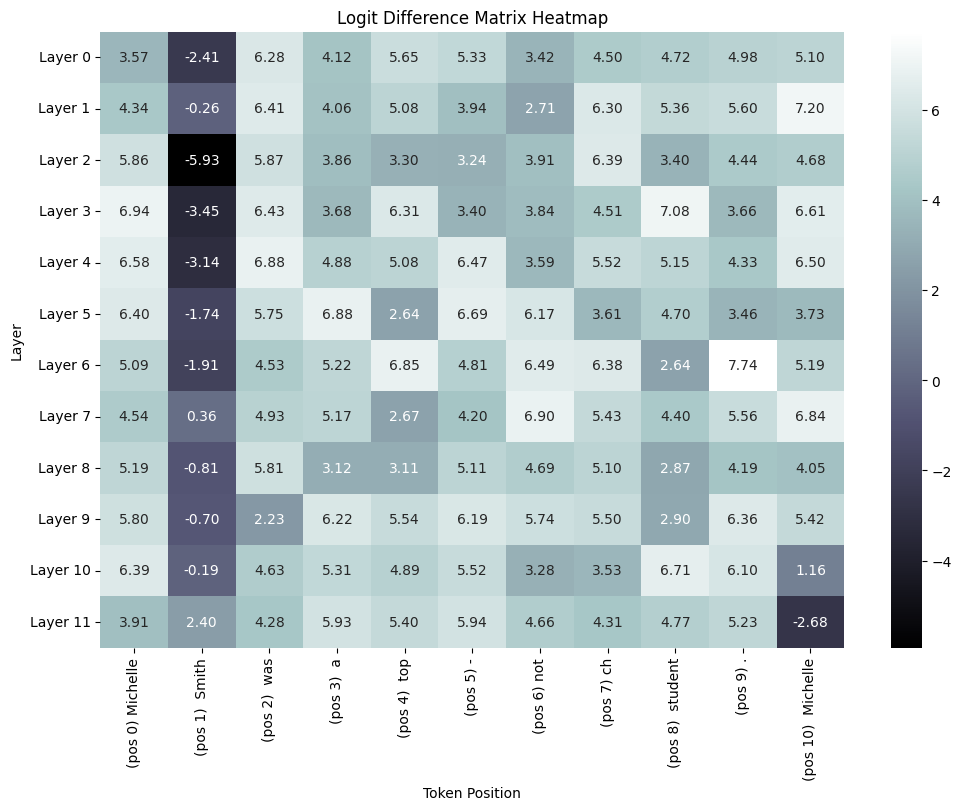

In [10]:
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(logit_diff_matrix.cpu().numpy(), cmap="bone", annot=True, fmt=".2f",
            xticklabels=[f"(pos {i}) {tokenizer.decode(torch.tensor([corrupted_tokens[i]]))}" for i in range(logit_diff_matrix.shape[1])],
            yticklabels=[f"Layer {i}" for i in range(logit_diff_matrix.shape[0])])
plt.title("Logit Difference Matrix Heatmap")
plt.xlabel("Token Position")
plt.ylabel("Layer")
plt.show()

In [28]:
# Function to do the test with 2 new texts
def test(model, clean_text, corrupted_text, token1, token2):
    # Tokenize texts
    clean_tokens = tokenizer(clean_text)[0]
    corrupted_tokens = tokenizer(corrupted_text)[0]
    assert clean_tokens.shape == corrupted_tokens.shape, "Tokens must have the same shape"
    print("Clean tokens shape: ", clean_tokens.shape)
    print("Corrupted tokens shape: ", corrupted_tokens.shape)
    print("Number of tokens:", clean_tokens.shape[0])

    # Generate from clean text
    clean_tokens = clean_tokens.unsqueeze(0).to(device)
    output = model.generate(clean_tokens, max_new_tokens=1, do_sample=False)
    print("Output from clean text:", tokenizer.decode(output[0].cpu()))

    # Copy the activations of the clean text
    clean_activations = [activation.clone().detach() for activation in model.activations]

    # Get the indices of the token1 and token2 tokens
    token1_index = tokenizer(token1)[0].item()
    token2_index = tokenizer(token2)[0].item()
    print(f"{token1} index:", token1_index)
    print(f"{token2} index:", token2_index)

    # Initialize matrix to store logit differences
    logit_diff_matrix = torch.zeros((12, len(corrupted_tokens)))

    # Iterate through layers and token positions
    for layer in range(12):
        for pos in range(len(corrupted_tokens)):
            embedding_to_patch = clean_activations[layer][0, pos].clone()

            # Generate output with the corrupted text making patches in layer, pos
            logits, _ = model.forward(corrupted_tokens.unsqueeze(0).to(device), patch_embedding={
                "layer": layer,
                "position": pos,
                "embedding": embedding_to_patch
            })

            # Compute logits for the last token
            logits = model.last_token_logits

            # Calculate logit difference between token1 and token2
            logit_diff = logits[0, token1_index] - logits[0, token2_index]

            # Store logit difference in the matrix
            logit_diff_matrix[layer, pos] = logit_diff.item()

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(logit_diff_matrix.cpu().numpy(), cmap="bone", annot=True, fmt=".2f",
                xticklabels=[f"(pos {i}) {tokenizer.decode(torch.tensor([corrupted_tokens[i]]))}" for i in range(logit_diff_matrix.shape[1])],
                yticklabels=[f"Layer {i}" for i in range(logit_diff_matrix.shape[0])])
    plt.title("Logit Difference Matrix Heatmap")
    plt.xlabel("Token Position")
    plt.ylabel("Layer")
    plt.show()

Clean tokens shape:  torch.Size([11])
Corrupted tokens shape:  torch.Size([11])
Number of tokens: 11
Output from clean text: Jessica Jones was a top-notch student. Michelle Obama
 Smith index: 4176
 Jones index: 5437


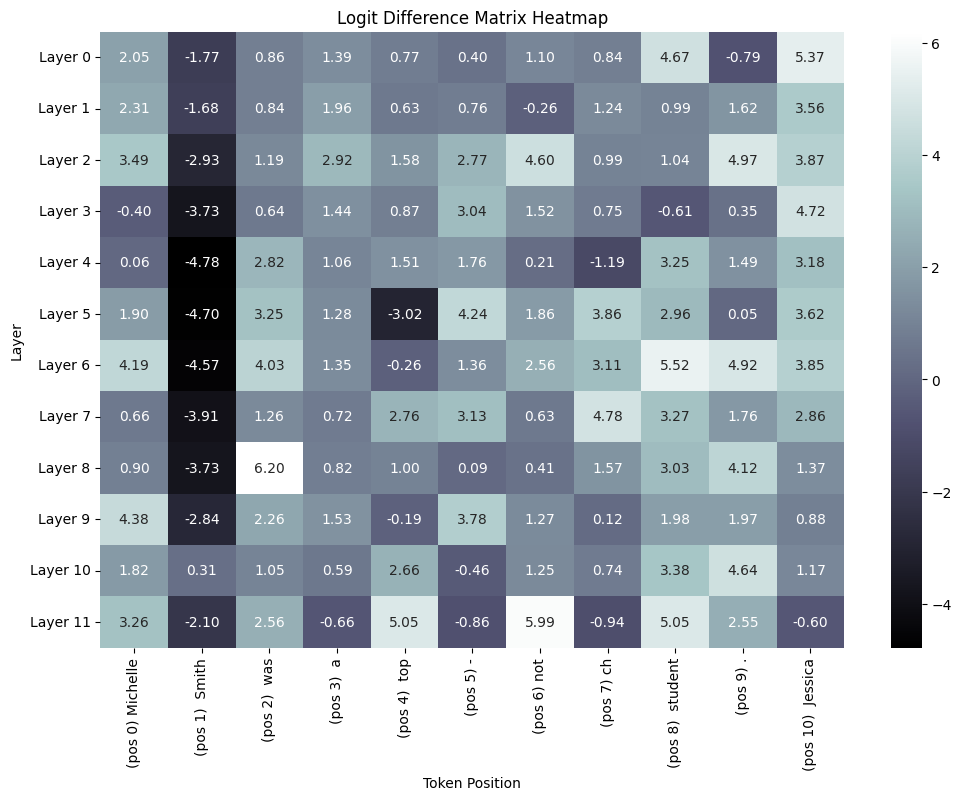

In [30]:
# Clean text
clean_text = "Jessica Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Jessica"

test(model, clean_text, corrupted_text, " Smith", " Jones")


Clean tokens shape:  torch.Size([7])
Corrupted tokens shape:  torch.Size([7])
Number of tokens: 7
Output from clean text: It ended in 1945. World War II
 I index: 314
 II index: 2873


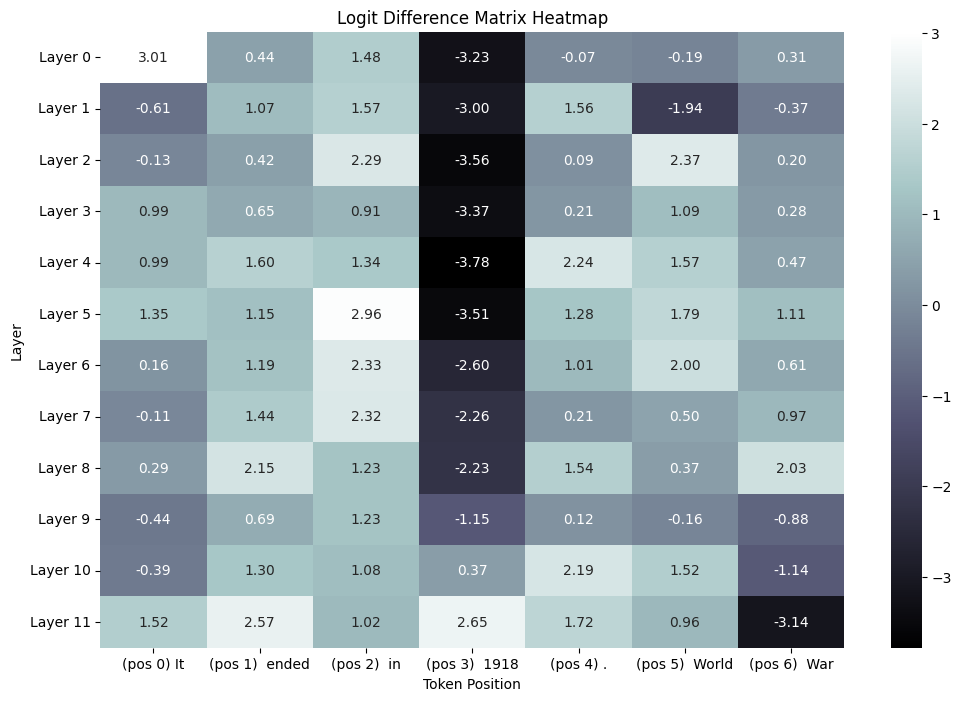

In [32]:
clean_text = "It ended in 1945. World War"
corrupted_text = "It ended in 1918. World War"

test(model, clean_text, corrupted_text, " I", " II")

Clean tokens shape:  torch.Size([12])
Corrupted tokens shape:  torch.Size([12])
Number of tokens: 12
Output from clean text: I love the Eiffel Tower however my favourite country is the
 France index: 4881
 Italy index: 8031


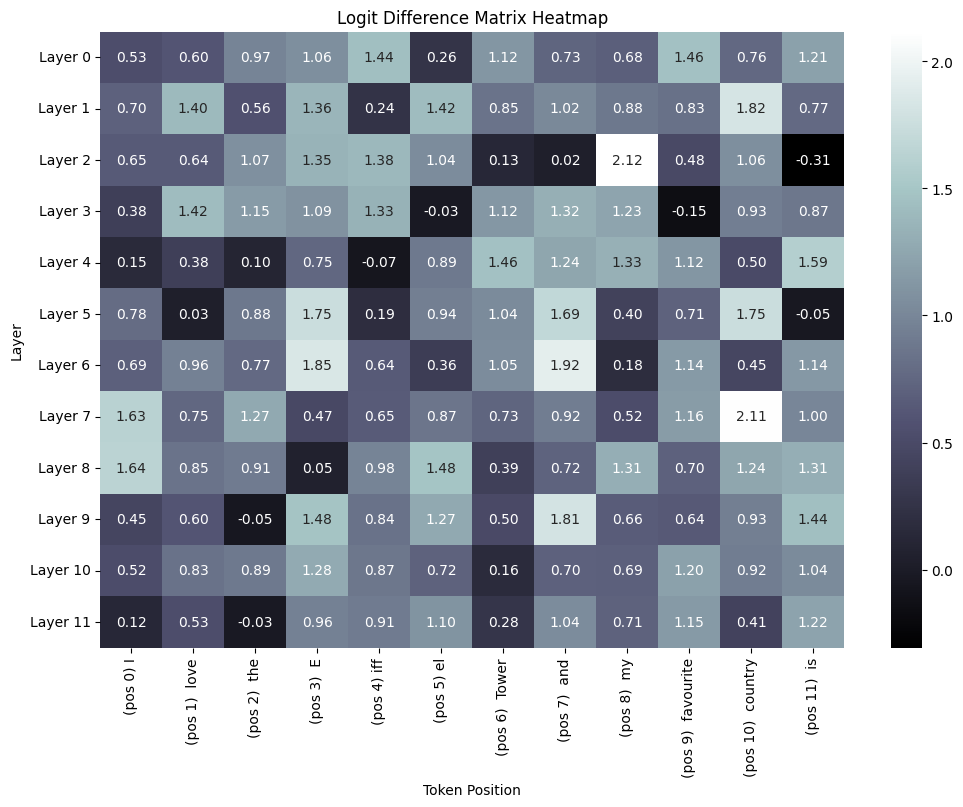

In [45]:
clean_text = "I love the Eiffel Tower however my favourite country is"
corrupted_text = "I love the Eiffel Tower and my favourite country is"

test(model, clean_text, corrupted_text, " France", " Italy")

Clean tokens shape:  torch.Size([13])
Corrupted tokens shape:  torch.Size([13])
Number of tokens: 13
Output from clean text: Lisa and Max went to the park and a flower was given to them
 Mary index: 5335
 Lisa index: 15378


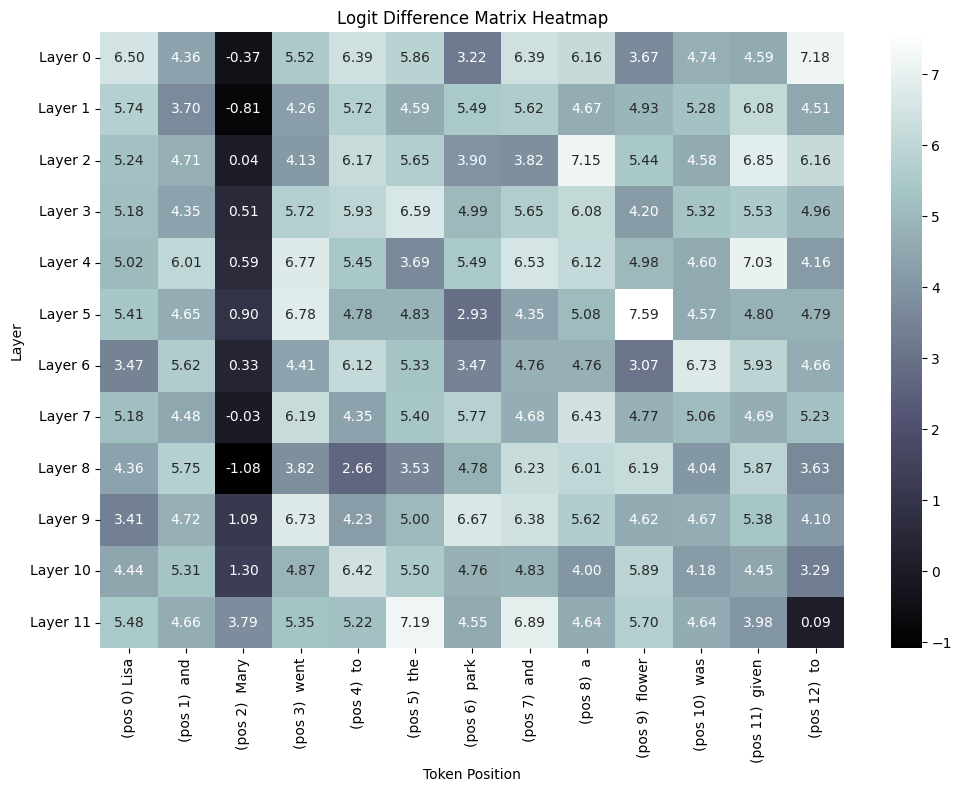

In [44]:
clean_text = "Lisa and Max went to the park and a flower was given to"
corrupted_text = "Lisa and Mary went to the park and a flower was given to"

test(model, clean_text, corrupted_text, " Mary", " Lisa")